In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings, string, nltk, random, gc, joblib
warnings.filterwarnings('ignore')
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from symspellpy import SymSpell, Verbosity

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [89]:
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from yellowbrick.classifier import ClassPredictionError
from sklearn.utils.class_weight import compute_class_weight

In [90]:
df = pd.read_csv("C:/Users/HP/Downloads/all_tickets_processed_improved_v3.csv")

In [91]:
df['Topic_group'].value_counts()

Topic_group
HR Support               231
Hardware                 177
Access                   175
Miscellaneous            159
Purchase                  95
Storage                   57
Internal Project          48
Administrative rights     14
Name: count, dtype: int64

In [92]:
df['num_words'] = df.Document.apply(len)
df.num_words.describe()

count     956.000000
mean      276.028243
std       514.522924
min        19.000000
25%        96.000000
50%       149.500000
75%       258.000000
max      6912.000000
Name: num_words, dtype: float64

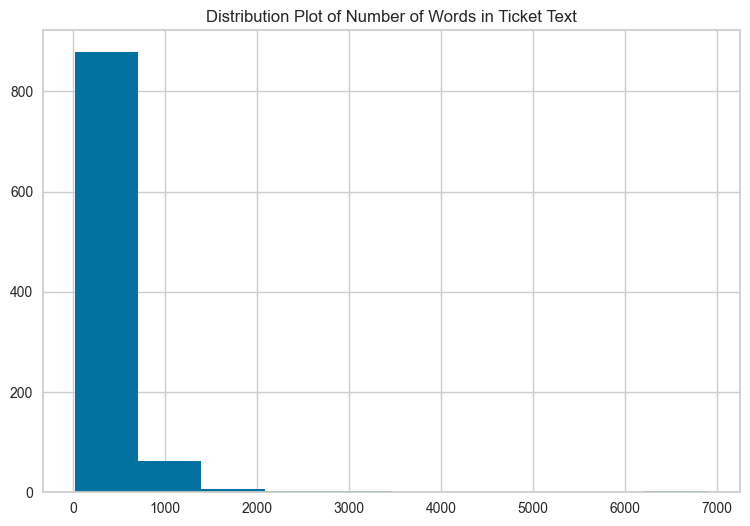

In [93]:
plt.figure(figsize=(9,6))
plt.hist(df['num_words'])
plt.title('Distribution Plot of Number of Words in Ticket Text')
plt.show();

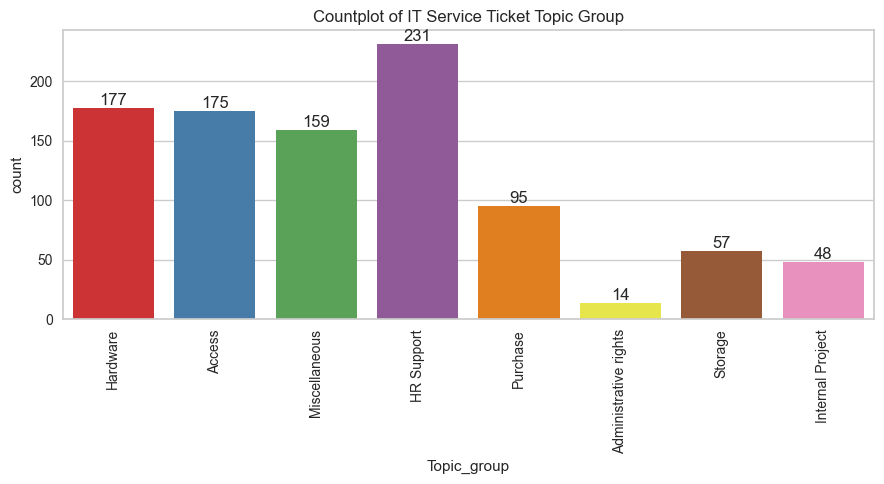

In [94]:
plt.figure(figsize=(9,5))
ax = sns.countplot(data=df, x='Topic_group', palette='Set1')
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0])
plt.title('Countplot of IT Service Ticket Topic Group')
plt.tight_layout()
plt.show();

In [95]:
def preprocess_text(text):
    words = [char.lower() for char in text if char not in string.punctuation]
    # print(f'words are {words}')
    words = "".join(words)
    # print(words)
    return " ".join([word for word in words.split() if word not in stopwords.words('english') and not words.isdigit()])

In [96]:
df['Document'] = df['Document'].apply(preprocess_text)

In [97]:
symspell = SymSpell()

def fix_spelling_mistakes(text):
    corrected_spellings = []

    for token in text.split():
        x = symspell.lookup(phrase=token,verbosity=Verbosity.CLOSEST,max_edit_distance=2,include_unknown=True)[0].__str__()
        y = x.split(',')[0]
        corrected_spellings.append(y)

    return ' '.join(corrected_spellings)

In [98]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [99]:
df['Document'] = df['Document'].apply(fix_spelling_mistakes).apply(lemmatize_words)

In [100]:
encoder = LabelEncoder()
df['topic'] = encoder.fit_transform(df.Topic_group)

In [101]:
unique_values, counts = np.unique(df.topic, return_counts=True)

In [102]:
df.head()

,Document,Topic_group,num_words,topic
0,connection icon icon dear please setup icon pe...,Hardware,111,3
1,work experience user work experience user hi w...,Access,124,0
2,requesting meeting requesting meeting hi pleas...,Hardware,93,3
3,reset password external account expire day hi ...,Access,948,0
4,mail verification warning hi got attached plea...,Miscellaneous,115,5


In [103]:
encoded_labels = dict()

for idx, label in enumerate(encoder.classes_):
    encoded_labels[idx] = label

print(encoded_labels)

{0: 'Access', 1: 'Administrative rights', 2: 'HR Support', 3: 'Hardware', 4: 'Internal Project', 5: 'Miscellaneous', 6: 'Purchase', 7: 'Storage'}


In [104]:
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(df.topic),y=df.topic)
class_weight_dict = dict(zip(np.unique(df.topic),class_weights))
class_weight_dict

{0: 0.6828571428571428,
 1: 8.535714285714286,
 2: 0.5173160173160173,
 3: 0.6751412429378532,
 4: 2.4895833333333335,
 5: 0.7515723270440252,
 6: 1.2578947368421052,
 7: 2.0964912280701755}

Feature Splitting

In [105]:
X = df['Document']
y = df['topic']

In [106]:
X.shape, y.shape

((956,), (956,))

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=101, stratify=y)

In [108]:
gc.collect()

6808

Model Training & Evaluation

In [109]:
model_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

In [78]:
def train_and_evaluate_model(model):
    pipeline = Pipeline(steps=[
        ('tfidf', TfidfVectorizer()),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test) 
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()

    # visualizer = ClassPredictionError(pipeline)
    # visualizer.fit(X_train, y_train)
    # visualizer.score(X_test, y_test)
    # visualizer.show()
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
    
    model_names.append(str(model).split('(')[0])
    accuracy_scores.append(acc)
    precision_scores.append(prec)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    
    gc.collect()
    
    return pipeline

Confusion Matrix:
[[1838   28   54   96   26   69    8   19]
 [   3  442    6   55    1   15    2    4]
 [  76   34 2652  223   72  154   15   49]
 [  80  186  222 3243   46  194   47   67]
 [   5    4   17   13  583   12    0    2]
 [  32   18   68  108   26 1824   10   32]
 [   3    5   10   28    2    7  681    3]
 [   6    9    3   23    3   15    1  773]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2138
           1       0.61      0.84      0.70       528
           2       0.87      0.81      0.84      3275
           3       0.86      0.79      0.82      4085
           4       0.77      0.92      0.84       636
           5       0.80      0.86      0.83      2118
           6       0.89      0.92      0.91       739
           7       0.81      0.93      0.87       833

    accuracy                           0.84     14352
   macro avg       0.81      0.87      0.84     14352
weighted avg      

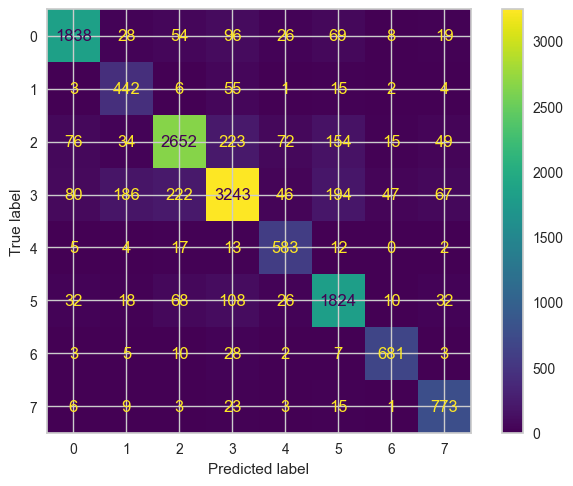

In [74]:
lr_pipeline = train_and_evaluate_model(LogisticRegression(class_weight=class_weight_dict))

Confusion Matrix:
[[1724   25   82  190   19   75    7   16]
 [  18  364   10  101    1   21    4    9]
 [ 115   22 2459  363   72  188   19   37]
 [ 162  146  370 2897   64  317   49   80]
 [  17    5   30   38  504   38    1    3]
 [  78   23  184  275   46 1457   12   43]
 [  10    4   15   68    5   11  625    1]
 [  18   11   22   76    3   20    4  679]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      2138
           1       0.61      0.69      0.65       528
           2       0.78      0.75      0.76      3275
           3       0.72      0.71      0.72      4085
           4       0.71      0.79      0.75       636
           5       0.69      0.69      0.69      2118
           6       0.87      0.85      0.86       739
           7       0.78      0.82      0.80       833

    accuracy                           0.75     14352
   macro avg       0.74      0.76      0.75     14352
weighted avg      

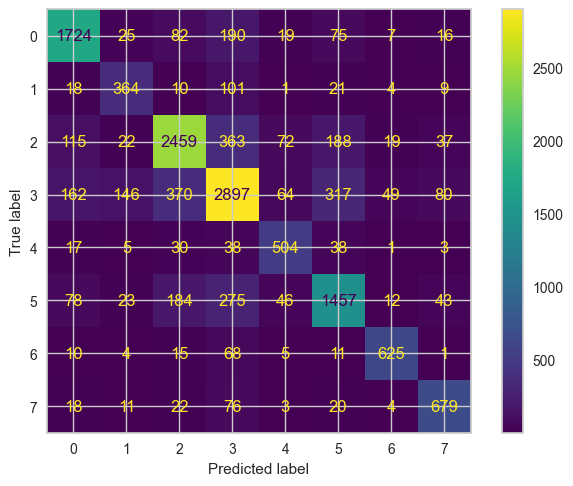

In [75]:
dt_pipeline = train_and_evaluate_model(DecisionTreeClassifier(class_weight=class_weight_dict))

Confusion Matrix:
[[1875    0   52  144   11   43    2   11]
 [   7  374   10  111    2   13    5    6]
 [  45    7 2767  309   29   93    8   17]
 [  78   33  201 3589   18  118   22   26]
 [  10    0   27   38  535   24    1    1]
 [  39   10   99  251   21 1680    4   14]
 [   6    3   13   53    2    4  656    2]
 [  11    6   16   60    0   11    0  729]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      2138
           1       0.86      0.71      0.78       528
           2       0.87      0.84      0.86      3275
           3       0.79      0.88      0.83      4085
           4       0.87      0.84      0.85       636
           5       0.85      0.79      0.82      2118
           6       0.94      0.89      0.91       739
           7       0.90      0.88      0.89       833

    accuracy                           0.85     14352
   macro avg       0.87      0.84      0.85     14352
weighted avg      

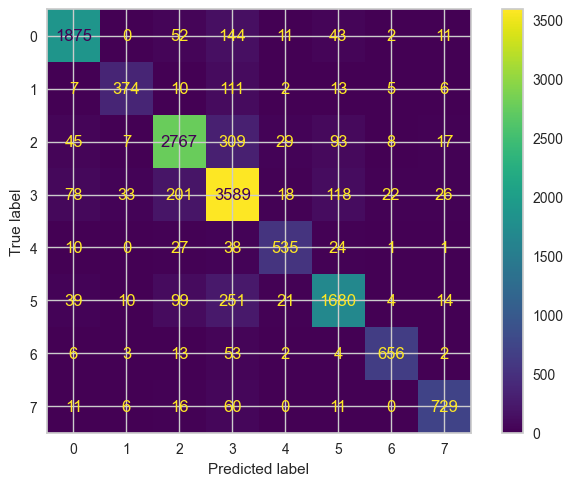

In [79]:
xgb_pipeline = train_and_evaluate_model(XGBClassifier())

Confusion Matrix:
[[1838    4   72  144    7   54    6   13]
 [   9  366   21  110    1   16    1    4]
 [  60   11 2774  274   28  103    7   18]
 [  69   38  239 3553   13  136   17   20]
 [   7    0   36   37  522   30    0    4]
 [  36    5  102  207   11 1743    4   10]
 [   5    2   15   39    1    4  670    3]
 [  10    6   10   64    2   17    0  724]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2138
           1       0.85      0.69      0.76       528
           2       0.85      0.85      0.85      3275
           3       0.80      0.87      0.83      4085
           4       0.89      0.82      0.86       636
           5       0.83      0.82      0.83      2118
           6       0.95      0.91      0.93       739
           7       0.91      0.87      0.89       833

    accuracy                           0.85     14352
   macro avg       0.87      0.84      0.85     14352
weighted avg      

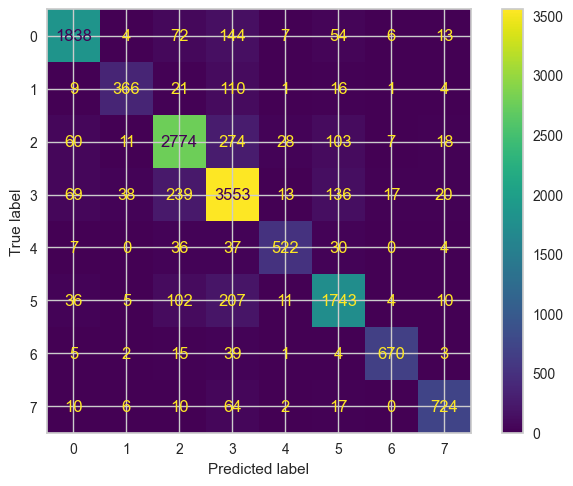

In [80]:
lsvc_pipeline = train_and_evaluate_model(CalibratedClassifierCV(LinearSVC(class_weight=class_weight_dict),method='sigmoid'))

In [110]:
model_perfs = pd.DataFrame({'Model': model_names,
                            'Accuracy': accuracy_scores,
                            'Precision': precision_scores,
                            'Recall': recall_scores,
                            'F1': f1_scores,
                            'ROC-AUC': roc_auc_scores}).sort_values('Accuracy',ascending=False).reset_index(drop=True)
model_perfs

,Model,Accuracy,Precision,Recall,F1,ROC-AUC


In [111]:
def predict(text:list , model=xgb_pipeline):
    results = model.predict(text)
    return encoded_labels.get(2,0)


In [112]:
predict(['access request dear modules report report cost thank much regards'])

'HR Support'